In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'ds': 'mnist',
    'distributed': True,
    'shuffle': True,
    'minibatch_size': 24,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': None,
    'display_images': True,
    'display_image_interval': 500,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
    'mixed_float': False,
    'continuous': False,
    'n_logistic_mix_components': 1,
})

config.discrete = not config.continuous

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[361 135  91 334 128 428 215  38 172 112   9  96  14 383 113  70 399 159
 291 285 125 128  61  60 307 170  39 240  50  48 117  62 193 135 227 199
  39  95 276 365 762  20  50 104   9  93 197 308 187 407 269  50  10  59
   7 108 310 225  54  72  53 393 338  58 216 205 486  86 222  66 193   3
 191 101 269 149  32 104 344  21 136  96 150  20 150  19 209  26 341 286
 412 128 388  26  56 180  14 102 274 108], shape=(100,), dtype=int32)
Init 1/3 with method k-means++
Inertia for init 1/3: 0.9286274917489564
Init 2/3 with method k-means++
Inertia for init 2/3: 0.874171501830961
Init 3/3 with method k-means++
Inertia for init 3/3: 1.2446752530391316
Minibatch step 1/100: mean batch inertia: 0.000880587576473289
Minibatch step 2/100: mean batch inertia: 0.0008991699353384014, ewa inertia: 0.0008991699353384014
Minibatch step 3/100: mean batch inertia: 0.0006180408653496062, ewa inertia: 0.0006180408653496062
Minibatch step 4/100: mean

Not using gradient accumulation


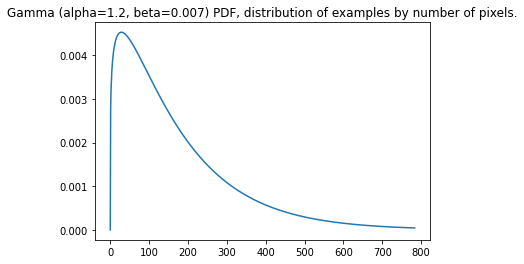

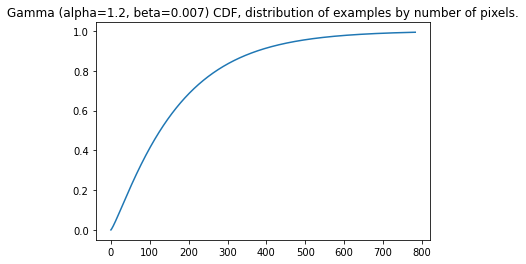

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'name': 'celeb_a',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


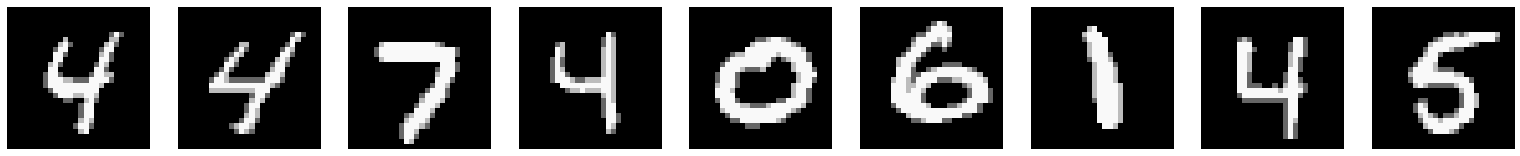

In [5]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
if config.continuous:
    display_colors = ds.reinvent_color_dim(display_colors)
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, do_unquantize=config.discrete, max_images=9)

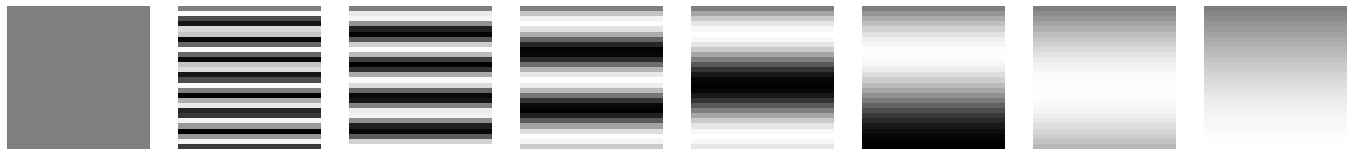

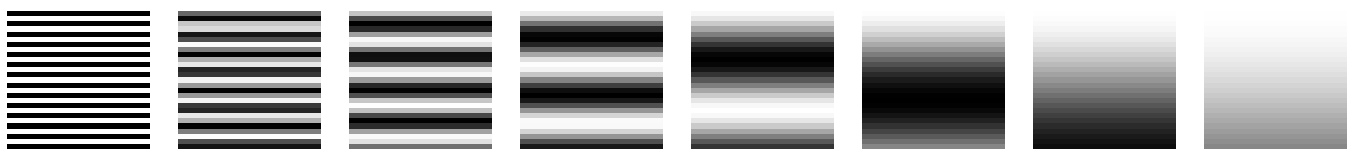

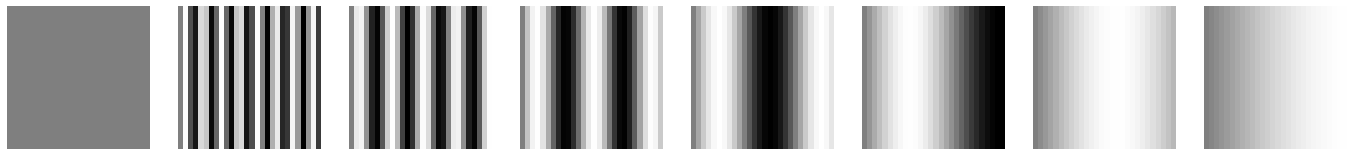

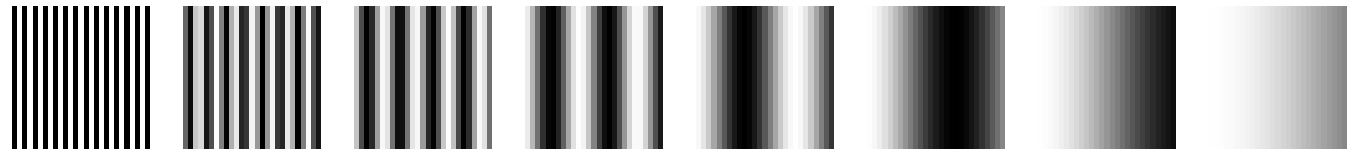

In [7]:
x_idx = tf.range(784)
pos_enc = models.pos_enc(n_dims=16, scale=100)
x = models.dual_positional_encoding((28,28), pos_enc)(x_idx)
x = x / 2. + 0.5
x = tf.expand_dims(tf.transpose(x), -1)
x_idx = tf.tile(x_idx[None, :], [16, 1])
viz.showSeq(x[:8], x_idx[:8], (28, 28), 8)
viz.showSeq(x[8:16], x_idx[8:16], (28, 28), 8)
viz.showSeq(x[16:24], x_idx[16:24], (28, 28), 8)
viz.showSeq(x[24:], x_idx[24:], (28, 28), 8)

In [ ]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'image_size': config.dataset.image_size,
    'seq_len': config.dataset.image_size[0] * config.dataset.image_size[1],
    'n_enc_a_layers': 6,
    'n_enc_b_layers': 3,
    'ffl_dim': 512,
    'embd_dim': 512,
    'n_dec_layers': 1,
    'dec_dim': 400,
    'n_heads': 8,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'deberta_anp',
    'position_embedding': 'pos_enc',
    'use_relative_positions': False,
    'activation': 'swish',
    'n_logistic_mix_components': config.n_logistic_mix_components
})

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))

if config.distributed:
    ds_train = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

import socket
model_name = models.model_name(config)
print(model_name)
# model.summary()

In [ ]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

In [ ]:


with strategy.scope():
    training_loop.train()

In [ ]:
model.save(f"models/{model_name}")

In [ ]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)

#### 